## Topic classification using BERT Embeddings

In [51]:
import pandas as pd
df_cleaned = pd.read_csv("../data/cleaned_merged_all_articles.csv", index_col=0).drop(columns=['title', 'representative_name', 'representative_state', 'representative_party', 'representative_committee', 'date'])
df = df_cleaned[~df_cleaned['issue'].str.contains(';')]
# selected_issues = [
#\t "Energy and Environment", "Education", "Health Care and Social Security", "Jobs and the Economy",
# 				"National Security, Defence, Foreign Affairs", "Veterans and Military"
#   ]
print(df.groupby("issue")["text"].count())
threshold = 150
selected_issues = [k for k,v in dict(df.groupby("issue")["text"].count()).items() if v > threshold]
df = df[df['issue'].isin(selected_issues)]
df.groupby("issue")["text"].count()

issue
2nd Amendment and Gun Violence                  306
Agriculture                                     758
Constitution                                     26
Disaster Relief & Preparedness                   67
Education                                      1411
Energy and Environment                         2380
Equality and Civil Rights                       511
Federal Budget and Taxes                        667
Government and Law                             1015
Health Care and Social Security                2930
Housing                                         115
Infrastructure and Transportation               823
Jobs and the Economy                           2333
Local issues                                    750
National Security, Defence, Foreign Affairs    3673
Pro-Life/Abortion and Family Values             141
Science, Technology, & Telecommunications       337
Supporting Seniors                              146
Veterans and Military                          1376
Name: 

issue
2nd Amendment and Gun Violence                  306
Agriculture                                     758
Education                                      1411
Energy and Environment                         2380
Equality and Civil Rights                       511
Federal Budget and Taxes                        667
Government and Law                             1015
Health Care and Social Security                2930
Infrastructure and Transportation               823
Jobs and the Economy                           2333
Local issues                                    750
National Security, Defence, Foreign Affairs    3673
Science, Technology, & Telecommunications       337
Veterans and Military                          1376
Name: text, dtype: int64

In [52]:
import re
import nltk
from nltk.stem import WordNetLemmatizer

stop_words_path = "./SmartStoplist.txt"
lemmatizer = WordNetLemmatizer()

def load_stop_words():
    stop_words = []
    with open(stop_words_path, "r") as f:
        stop_words = f.read().split("\n")
    return set(stop_words)

def preprocess_text(text: str, stopwords) -> str:
    text = re.sub(r"http\S+", "", text) # remove links
    text = re.sub("[^A-Za-z]+", " ", text) # remove special characters and numbers
    tokens = nltk.word_tokenize(text.lower()) # tokenization
    tokens = [w for w in tokens if not w in stopwords] # remove stop words
    tokens = [lemmatizer.lemmatize(w) for w in tokens] # remove stop words + lemmatization
    text = " ".join(tokens)
    text = text.lower().strip()
    return text


stopwords = load_stop_words()
df.loc[:, "text"] = df["text"].apply(lambda text: preprocess_text(text, stopwords))
df = df[df["text"] != ""]

We want to use BERT solely for generating embeddings and then feed those embeddings into a separate neural network for classification, so we freeze the BERT model and use it as a feature extractor. This approach significantly reduces computational cost compared to fine-tuning the entire BERT model.

In [53]:
most_common_words=[
    'state', 'act', 'community', 'federal', 'year', 'american', 'rep', 'house', 'congressman', 'program', 'today', 'service', 'support', 'member', 'committee'
]

CountVectorizer creates a Bag of Words representation of the text data.

In [54]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch import nn
import torch
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

# Encode labels
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['issue'])

# Split the dataset
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['text'], df['label'], test_size=0.2, random_state=42, stratify=df['label']
)

# Initialize CountVectorizer for BoW
vectorizer = CountVectorizer(ngram_range=(1,4), stop_words=most_common_words, min_df=100)
train_embeddings = vectorizer.fit_transform(train_texts.tolist()).toarray()
val_embeddings = vectorizer.transform(val_texts.tolist()).toarray()

# Convert to tensors
train_embeddings_tensor = torch.tensor(train_embeddings, dtype=torch.float32)
val_embeddings_tensor = torch.tensor(val_embeddings, dtype=torch.float32)

train_labels_tensor = torch.tensor(train_labels.values, dtype=torch.long)
val_labels_tensor = torch.tensor(val_labels.values, dtype=torch.long)

# Create datasets
train_dataset = TensorDataset(train_embeddings_tensor, train_labels_tensor)
val_dataset = TensorDataset(val_embeddings_tensor, val_labels_tensor)

# Data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

Troubles with Count vectorizer:
```
Unable to allocate 404. GiB for an array with shape (11282, 4805714) and data type int64
```

In [6]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, model, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
            torch.save(model.state_dict(), 'checkpoint.pt')
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


class SimpleNN(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(SimpleNN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.fc(x)


def train(classifier, criterion, optimizer, train_loader, val_loader, epochs=30, patience=3, min_delta=10):
	if patience is None or min_delta is None:
		early_stopper = lambda x: False
	else:
		early_stopper = EarlyStopper(patience=patience, min_delta=min_delta)

	losses = []
	val_losses = []
	for epoch in range(epochs):  # Train for 10 epochs
					classifier.train()
					for batch in train_loader:
									optimizer.zero_grad()

									embeddings, labels = batch
									embeddings = embeddings.to(device)
									labels = labels.to(device).long()

									outputs = classifier(embeddings)
									loss = criterion(outputs, labels)
									loss.backward()
									optimizer.step()
									

					final_loss = loss.item()
					classifier.eval()
					with torch.no_grad():
						for batch in val_loader:
							embeddings, labels = batch
							embeddings = embeddings.to(device)
							labels = labels.to(device).long()

							outputs = classifier(embeddings)
							val_loss = criterion(outputs, labels).item()
					print(f"Epoch {epoch + 1}, Loss: {final_loss}, Val loss: {val_loss}")
					losses.append(final_loss)
					val_losses.append(val_loss)
					if early_stopper.early_stop(classifier, val_loss):
						break
  
	if patience is not None and min_delta is not None:
		classifier.load_state_dict(torch.load('checkpoint.pt', weights_only=True))

	return losses, val_losses

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [8]:
def evaluate(classifier, val_loader):
	classifier.eval()
	all_predictions = []
	all_labels = []
	with torch.no_grad():
					for batch in val_loader:
									embeddings, labels = batch
									embeddings = embeddings.to(device)
									labels = labels.to(device).long()

									outputs = classifier(embeddings)
									predictions = torch.argmax(outputs, dim=-1)

									all_predictions.extend(predictions.cpu().numpy())
									all_labels.extend(labels.cpu().numpy())

	# Generate classification report
	print(classification_report(all_labels, all_predictions, target_names=label_encoder.classes_))

	# Generate confusion matrix
	cm = confusion_matrix(all_labels, all_predictions)
	cm_display_labels = label_encoder.classes_

	# Plot confusion matrix
	plt.figure(figsize=(10, 8))
	sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=cm_display_labels, yticklabels=cm_display_labels)
	plt.xlabel('Predicted Label')
	plt.ylabel('True Label')
	plt.title('Confusion Matrix')
	plt.show()

In [12]:
model_simple = SimpleNN(input_dim=train_embeddings_tensor.size(1), num_classes=len(df['issue'].unique()))
model_simple.to(device)

criterion_cros_entr_loss = nn.CrossEntropyLoss()
optimizer_adam = torch.optim.Adam(model_simple.parameters(), lr=5e-5, weight_decay=1e-6)
losses, val_losses = train(model_simple, criterion_cros_entr_loss, optimizer_adam, train_loader, val_loader, 500, patience=3, min_delta=2)

Epoch 1, Loss: 1.1762654781341553, Val loss: 0.7478896379470825
Epoch 2, Loss: 0.9866210222244263, Val loss: 0.32886701822280884
Epoch 3, Loss: 0.4357984662055969, Val loss: 0.20505623519420624
Epoch 4, Loss: 0.4359325170516968, Val loss: 0.16053013503551483
Epoch 5, Loss: 0.22469159960746765, Val loss: 0.13479550182819366
Epoch 6, Loss: 0.30465567111968994, Val loss: 0.11949064582586288
Epoch 7, Loss: 0.30678480863571167, Val loss: 0.12382876873016357
Epoch 8, Loss: 0.2010870724916458, Val loss: 0.10957331955432892
Epoch 9, Loss: 0.4294702112674713, Val loss: 0.10668430477380753
Epoch 10, Loss: 0.25567057728767395, Val loss: 0.10260077565908432
Epoch 11, Loss: 0.2189571112394333, Val loss: 0.08933712542057037
Epoch 12, Loss: 0.12527327239513397, Val loss: 0.095523402094841
Epoch 13, Loss: 0.13198398053646088, Val loss: 0.08492954075336456
Epoch 14, Loss: 0.8203964829444885, Val loss: 0.0861203670501709
Epoch 15, Loss: 0.13473013043403625, Val loss: 0.07247459888458252
Epoch 16, Loss: 

                                             precision    recall  f1-score   support

                                  Education       0.87      0.84      0.86       282
                     Energy and Environment       0.89      0.91      0.90       476
            Health Care and Social Security       0.88      0.90      0.89       586
                       Jobs and the Economy       0.86      0.82      0.84       467
National Security, Defence, Foreign Affairs       0.90      0.93      0.91       735
                      Veterans and Military       0.87      0.82      0.84       275

                                   accuracy                           0.88      2821
                                  macro avg       0.88      0.87      0.87      2821
                               weighted avg       0.88      0.88      0.88      2821



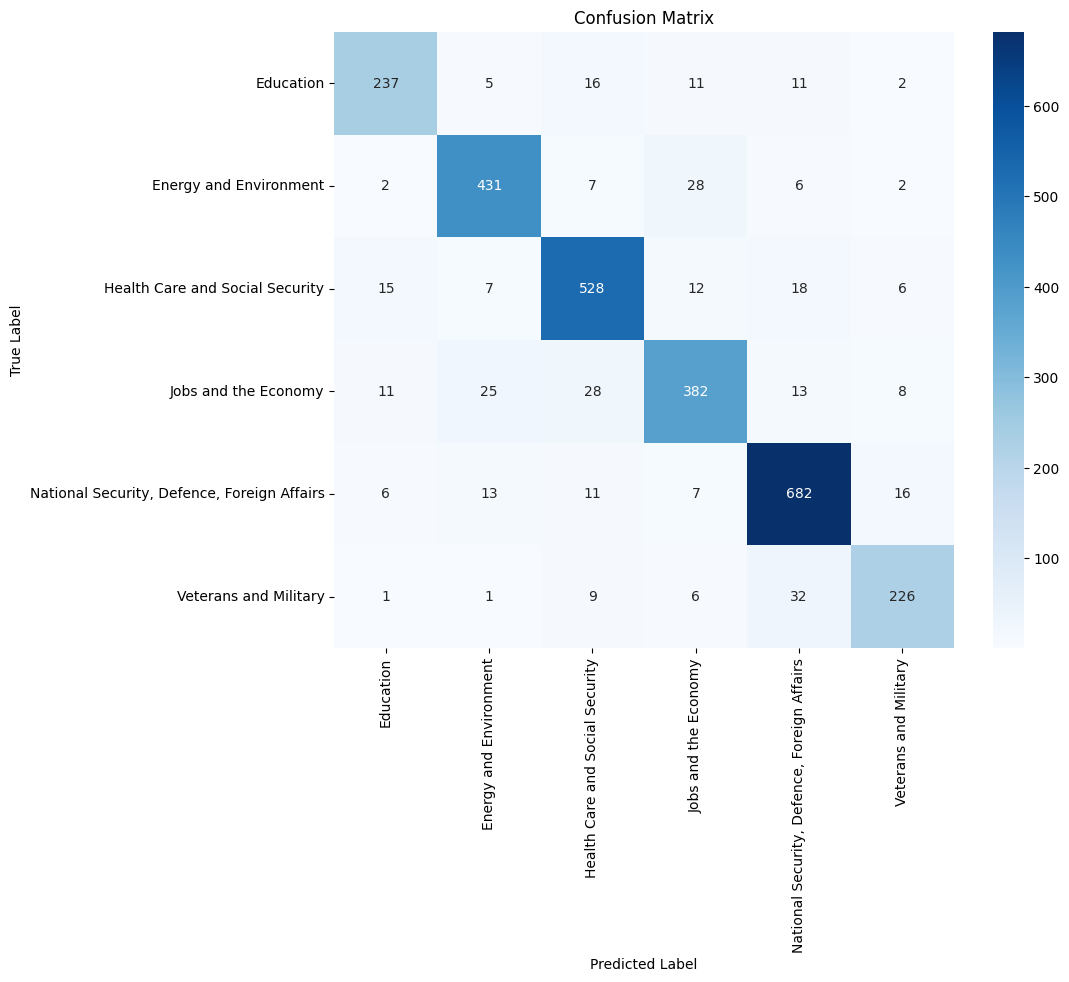

In [13]:
evaluate(model_simple, val_loader)

In [14]:
import matplotlib.pyplot as plt

def plot_training(losses, val_losses, start_epoch = 0, end_epoch=-1):
	plt.figure(figsize=(8, 6))
	plt.plot(list(range(1, len(losses[start_epoch:end_epoch])+1)), losses[start_epoch:end_epoch], marker='o', linestyle='-', color='r', label='Train Loss')
	plt.plot(list(range(1, len(val_losses[start_epoch:end_epoch])+1)), val_losses[start_epoch:end_epoch], marker='o', linestyle='-', color='b', label='Validation Loss')

	# Add labels and title
	plt.xlabel('Epoch')
	plt.ylabel('Training loss')
	plt.title('Training and validation loss (1st model)')
	plt.legend()

	# Show the plot
	plt.grid()
	plt.show()

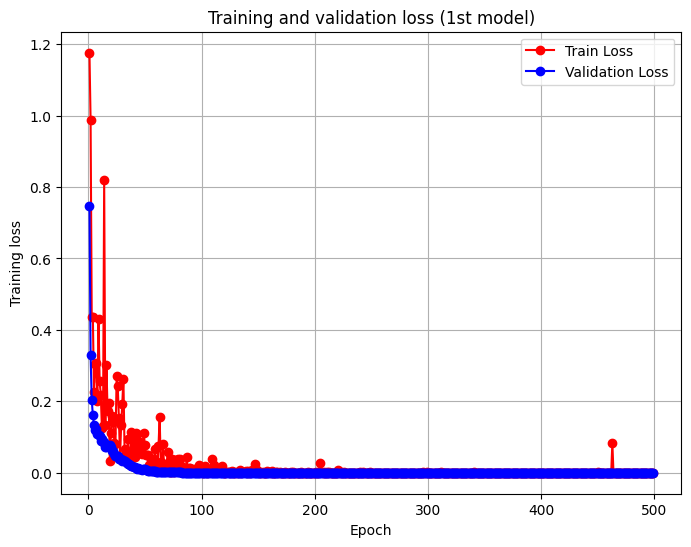

In [16]:
plot_training(losses, val_losses)

---

## Slightly more difficult model

In [60]:
class SlightlyMoreDifficultNN(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(SlightlyMoreDifficultNN, self).__init__()
        self.fc = nn.Sequential(
								nn.Linear(input_dim, 256),
								nn.ReLU(),
								nn.Dropout(0.4),
								nn.Linear(256, 128),
								nn.ReLU(),
								nn.Dropout(0.3),
								nn.Linear(128, num_classes)
							)

    def forward(self, x):
        return self.fc(x)

In [61]:
model_more_diff = SlightlyMoreDifficultNN(input_dim=train_embeddings_tensor.size(1), num_classes=len(df['issue'].unique()))
model_more_diff.to(device)

optimizer_adam_diff = torch.optim.Adam(model_more_diff.parameters(), lr=5e-5, weight_decay=1e-6)
losses, val_losses = train(model_more_diff, criterion_cros_entr_loss, optimizer_adam_diff, train_loader, val_loader, 300, patience=3, min_delta=2)

Epoch 1, Loss: 1.464520812034607, Val loss: 1.1016817092895508
Epoch 2, Loss: 1.201130986213684, Val loss: 0.7120305299758911
Epoch 3, Loss: 1.0396924018859863, Val loss: 0.6119018197059631
Epoch 4, Loss: 0.7907094955444336, Val loss: 0.5552929639816284
Epoch 5, Loss: 0.8058069348335266, Val loss: 0.5240945816040039
Epoch 6, Loss: 1.0197839736938477, Val loss: 0.5390331149101257
Epoch 7, Loss: 1.2178301811218262, Val loss: 0.6284977793693542
Epoch 8, Loss: 0.25414901971817017, Val loss: 0.6648548245429993
Epoch 9, Loss: 0.33730050921440125, Val loss: 0.6628900766372681
Epoch 10, Loss: 0.6588161587715149, Val loss: 0.8243889212608337
Epoch 11, Loss: 0.3436407148838043, Val loss: 0.8534623384475708
Epoch 12, Loss: 0.257152795791626, Val loss: 0.854573667049408
Epoch 13, Loss: 0.5486916303634644, Val loss: 0.8513203263282776
Epoch 14, Loss: 0.32749003171920776, Val loss: 0.9534897208213806
Epoch 15, Loss: 0.8494689464569092, Val loss: 1.0709882974624634
Epoch 16, Loss: 0.23728816211223602

                                             precision    recall  f1-score   support

             2nd Amendment and Gun Violence       0.88      0.75      0.81        61
                                Agriculture       0.89      0.82      0.85       152
                                  Education       0.85      0.90      0.87       282
                     Energy and Environment       0.83      0.86      0.84       476
                  Equality and Civil Rights       0.92      0.60      0.73       102
                   Federal Budget and Taxes       0.81      0.38      0.52       133
                         Government and Law       0.80      0.50      0.61       203
            Health Care and Social Security       0.89      0.91      0.90       586
          Infrastructure and Transportation       0.82      0.67      0.74       165
                       Jobs and the Economy       0.65      0.79      0.71       467
                               Local issues       0.79      0.67

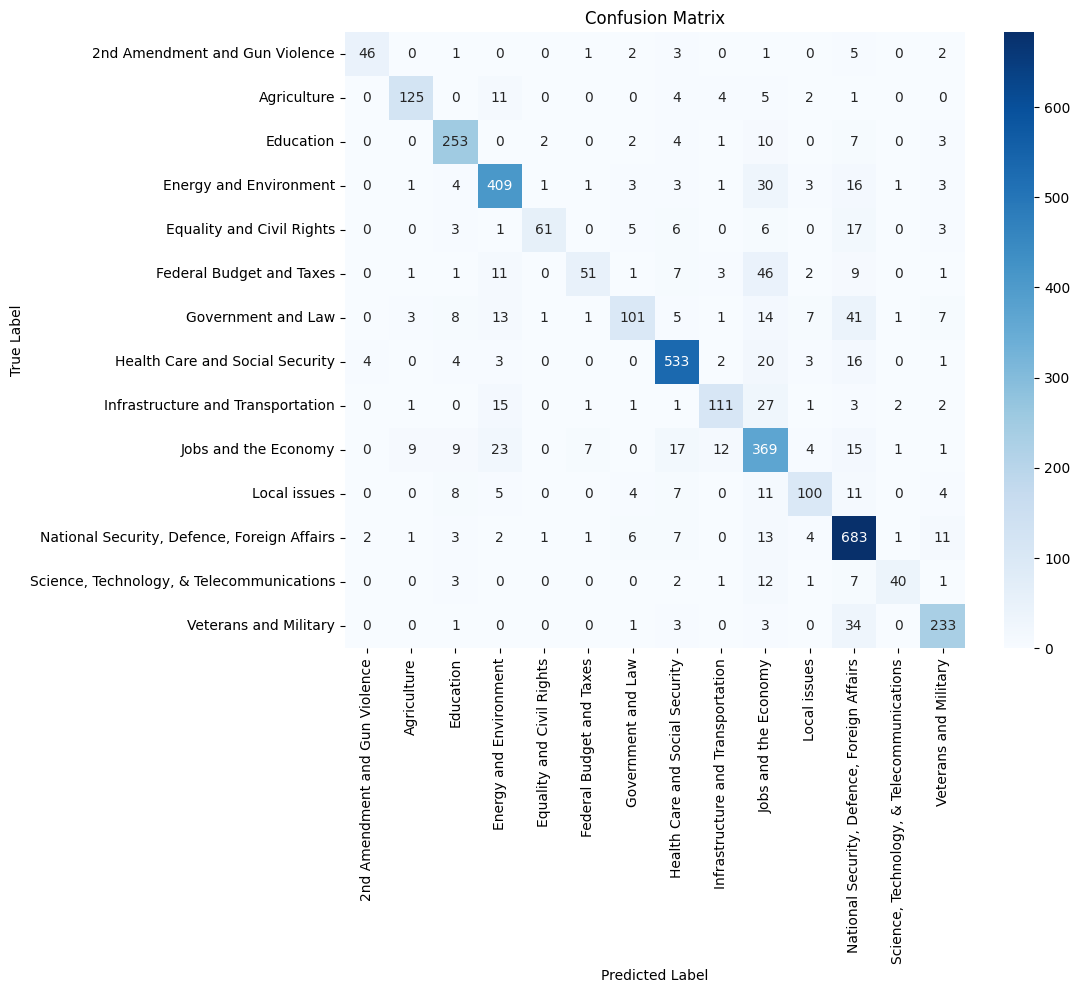

In [62]:
evaluate(model_more_diff, val_loader)

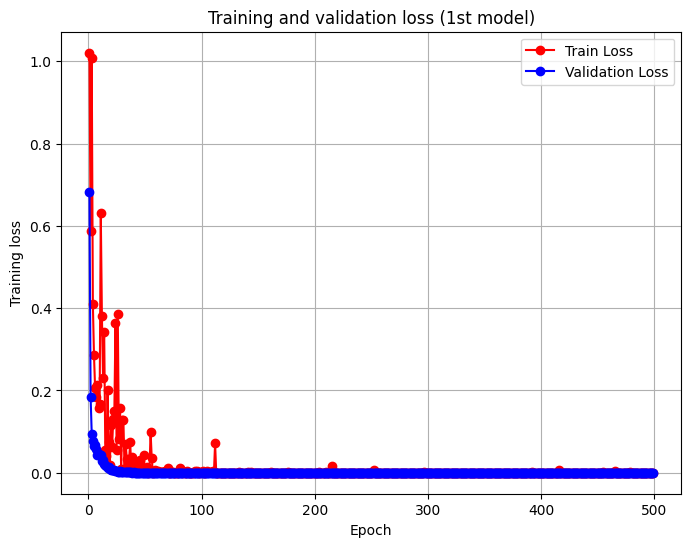

In [30]:
plot_training(losses, val_losses)

----

In [32]:
class SimpleNN2(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(SimpleNN2, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        return self.fc(x)

In [34]:
model = SimpleNN2(input_dim=train_embeddings_tensor.size(1), num_classes=len(df['issue'].unique()))
model.to(device)

optimizer_adam = torch.optim.Adam(model.parameters(), lr=5e-5, weight_decay=1e-6)
losses, val_losses = train(model, criterion_cros_entr_loss, optimizer_adam, train_loader, val_loader, 500, patience=3, min_delta=2)

Epoch 1, Loss: 1.5013020038604736, Val loss: 1.372208833694458
Epoch 2, Loss: 1.176231026649475, Val loss: 0.5370429158210754
Epoch 3, Loss: 0.6659669280052185, Val loss: 0.27179116010665894
Epoch 4, Loss: 0.9891300201416016, Val loss: 0.17409078776836395
Epoch 5, Loss: 0.4288425147533417, Val loss: 0.11781631410121918
Epoch 6, Loss: 0.2916196584701538, Val loss: 0.09169688820838928
Epoch 7, Loss: 0.5050843358039856, Val loss: 0.0723748430609703
Epoch 8, Loss: 0.3579453229904175, Val loss: 0.06257840245962143
Epoch 9, Loss: 0.09827151894569397, Val loss: 0.05383402109146118
Epoch 10, Loss: 0.6169055104255676, Val loss: 0.05008717626333237
Epoch 11, Loss: 0.3207534849643707, Val loss: 0.04420708492398262
Epoch 12, Loss: 0.44821420311927795, Val loss: 0.04536589980125427
Epoch 13, Loss: 0.1873878836631775, Val loss: 0.03911592811346054
Epoch 14, Loss: 0.41126611828804016, Val loss: 0.03166981786489487
Epoch 15, Loss: 0.6556299328804016, Val loss: 0.03247169032692909
Epoch 16, Loss: 0.409

                                             precision    recall  f1-score   support

                                  Education       0.87      0.87      0.87       282
                     Energy and Environment       0.91      0.91      0.91       476
            Health Care and Social Security       0.89      0.92      0.90       586
                       Jobs and the Economy       0.83      0.82      0.83       467
National Security, Defence, Foreign Affairs       0.90      0.92      0.91       735
                      Veterans and Military       0.88      0.82      0.85       275

                                   accuracy                           0.89      2821
                                  macro avg       0.88      0.88      0.88      2821
                               weighted avg       0.89      0.89      0.89      2821



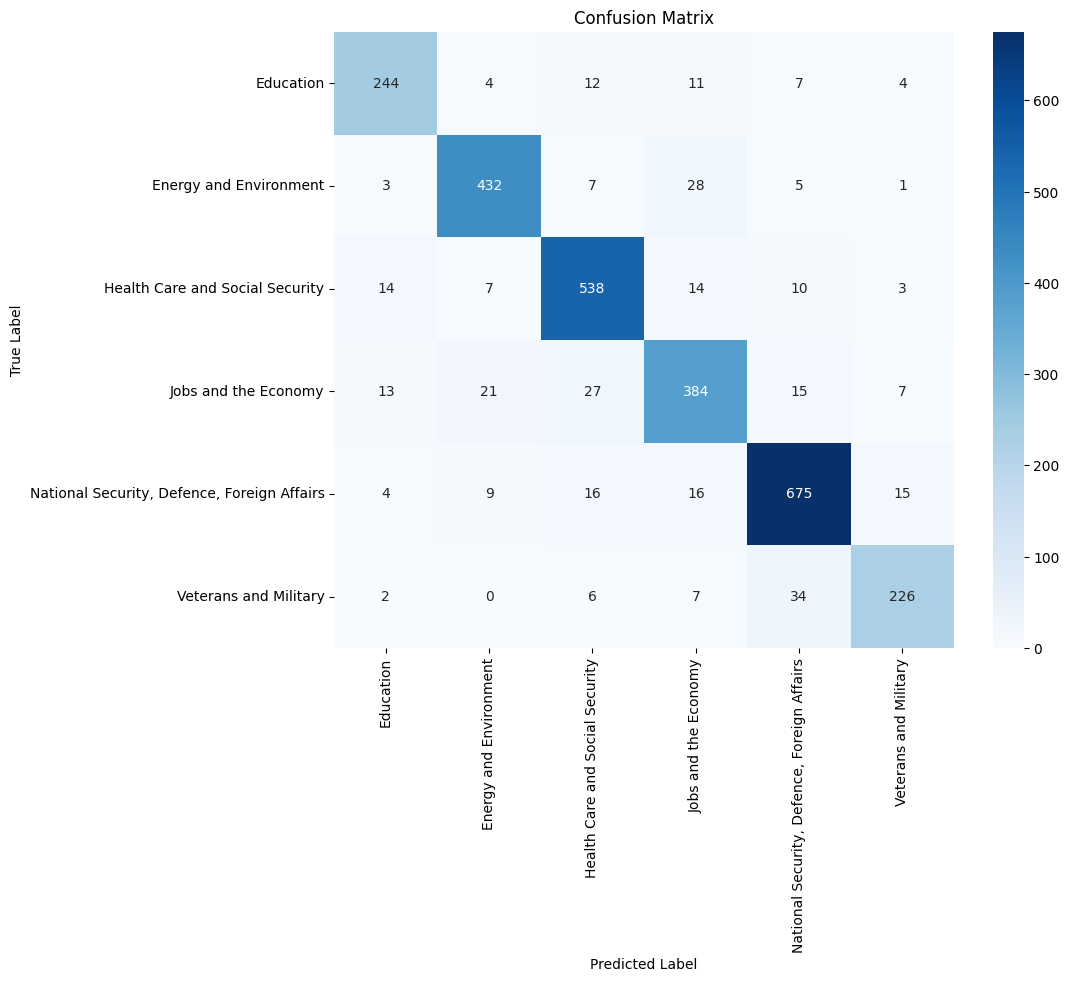

In [35]:
evaluate(model, val_loader)

---

In [63]:
class SimpleNN3(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(SimpleNN3, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        return self.fc(x)

In [64]:
model = SimpleNN3(input_dim=train_embeddings_tensor.size(1), num_classes=len(df['issue'].unique()))
model.to(device)

optimizer_adam = torch.optim.Adam(model.parameters(), lr=5e-5, weight_decay=1e-6)
losses, val_losses = train(model, criterion_cros_entr_loss, optimizer_adam, train_loader, val_loader, 500, patience=3, min_delta=2)

Epoch 1, Loss: 2.2391269207000732, Val loss: 1.8260324001312256
Epoch 2, Loss: 1.8944698572158813, Val loss: 1.3292791843414307
Epoch 3, Loss: 1.7691456079483032, Val loss: 0.9958635568618774
Epoch 4, Loss: 1.5108193159103394, Val loss: 0.8461310267448425
Epoch 5, Loss: 1.194867491722107, Val loss: 0.7612605094909668
Epoch 6, Loss: 1.3175798654556274, Val loss: 0.7053973078727722
Epoch 7, Loss: 1.0179978609085083, Val loss: 0.6877986192703247
Epoch 8, Loss: 1.4267935752868652, Val loss: 0.6225113272666931
Epoch 9, Loss: 1.0677889585494995, Val loss: 0.6524279713630676
Epoch 10, Loss: 0.717681884765625, Val loss: 0.5771665573120117
Epoch 11, Loss: 1.303442358970642, Val loss: 0.5639238953590393
Epoch 12, Loss: 0.49638843536376953, Val loss: 0.6304776072502136
Epoch 13, Loss: 0.5435733199119568, Val loss: 0.703822910785675
Epoch 14, Loss: 1.454229712486267, Val loss: 0.5815179944038391
Epoch 15, Loss: 0.6980900764465332, Val loss: 0.6466905474662781
Epoch 16, Loss: 0.8544695973396301, Va

/home/paulina/usa_issues_data_mining/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/paulina/usa_issues_data_mining/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/paulina/usa_issues_data_mining/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

                                             precision    recall  f1-score   support

             2nd Amendment and Gun Violence       0.88      0.49      0.63        61
                                Agriculture       0.68      0.80      0.73       152
                                  Education       0.79      0.87      0.83       282
                     Energy and Environment       0.78      0.89      0.83       476
                  Equality and Civil Rights       0.83      0.05      0.09       102
                   Federal Budget and Taxes       0.00      0.00      0.00       133
                         Government and Law       0.54      0.37      0.44       203
            Health Care and Social Security       0.90      0.89      0.90       586
          Infrastructure and Transportation       0.65      0.69      0.67       165
                       Jobs and the Economy       0.59      0.76      0.67       467
                               Local issues       0.58      0.57

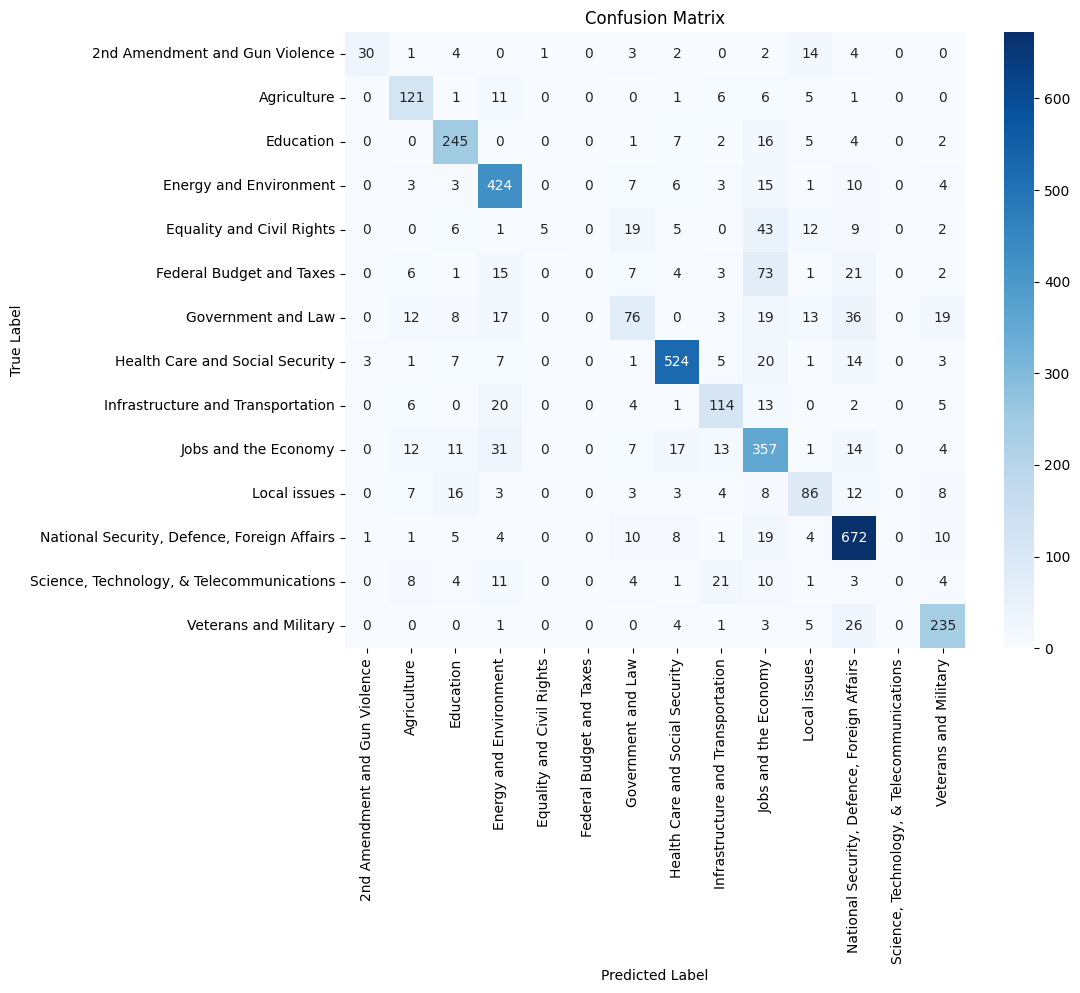

In [65]:
evaluate(model, val_loader)

In [39]:
class SimpleNN4(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(SimpleNN4, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        return self.fc(x)

In [40]:
model = SimpleNN4(input_dim=train_embeddings_tensor.size(1), num_classes=len(df['issue'].unique()))
model.to(device)

optimizer_adam = torch.optim.Adam(model.parameters(), lr=5e-5, weight_decay=1e-6)
losses, val_losses = train(model, criterion_cros_entr_loss, optimizer_adam, train_loader, val_loader, 500, patience=3, min_delta=2)

Epoch 1, Loss: 1.7146497964859009, Val loss: 1.5024778842926025
Epoch 2, Loss: 1.1274919509887695, Val loss: 0.5538345575332642
Epoch 3, Loss: 0.5961098074913025, Val loss: 0.2822912931442261
Epoch 4, Loss: 0.4910483956336975, Val loss: 0.14783385396003723
Epoch 5, Loss: 0.3095417320728302, Val loss: 0.06635072827339172
Epoch 6, Loss: 0.38611042499542236, Val loss: 0.05205022171139717
Epoch 7, Loss: 0.3381524682044983, Val loss: 0.04657960310578346
Epoch 8, Loss: 0.4565555155277252, Val loss: 0.046807967126369476
Epoch 9, Loss: 0.38190630078315735, Val loss: 0.027353504672646523
Epoch 10, Loss: 0.3639638423919678, Val loss: 0.02629944309592247
Epoch 11, Loss: 0.38167133927345276, Val loss: 0.024861637502908707
Epoch 12, Loss: 0.08372033387422562, Val loss: 0.020479824393987656
Epoch 13, Loss: 0.30827367305755615, Val loss: 0.01252798456698656
Epoch 14, Loss: 0.0741095170378685, Val loss: 0.015516616404056549
Epoch 15, Loss: 0.5090178847312927, Val loss: 0.011286130174994469
Epoch 16, L

                                             precision    recall  f1-score   support

                                  Education       0.87      0.86      0.86       282
                     Energy and Environment       0.92      0.91      0.91       476
            Health Care and Social Security       0.91      0.89      0.90       586
                       Jobs and the Economy       0.81      0.83      0.82       467
National Security, Defence, Foreign Affairs       0.90      0.91      0.91       735
                      Veterans and Military       0.85      0.84      0.85       275

                                   accuracy                           0.88      2821
                                  macro avg       0.88      0.87      0.87      2821
                               weighted avg       0.88      0.88      0.88      2821



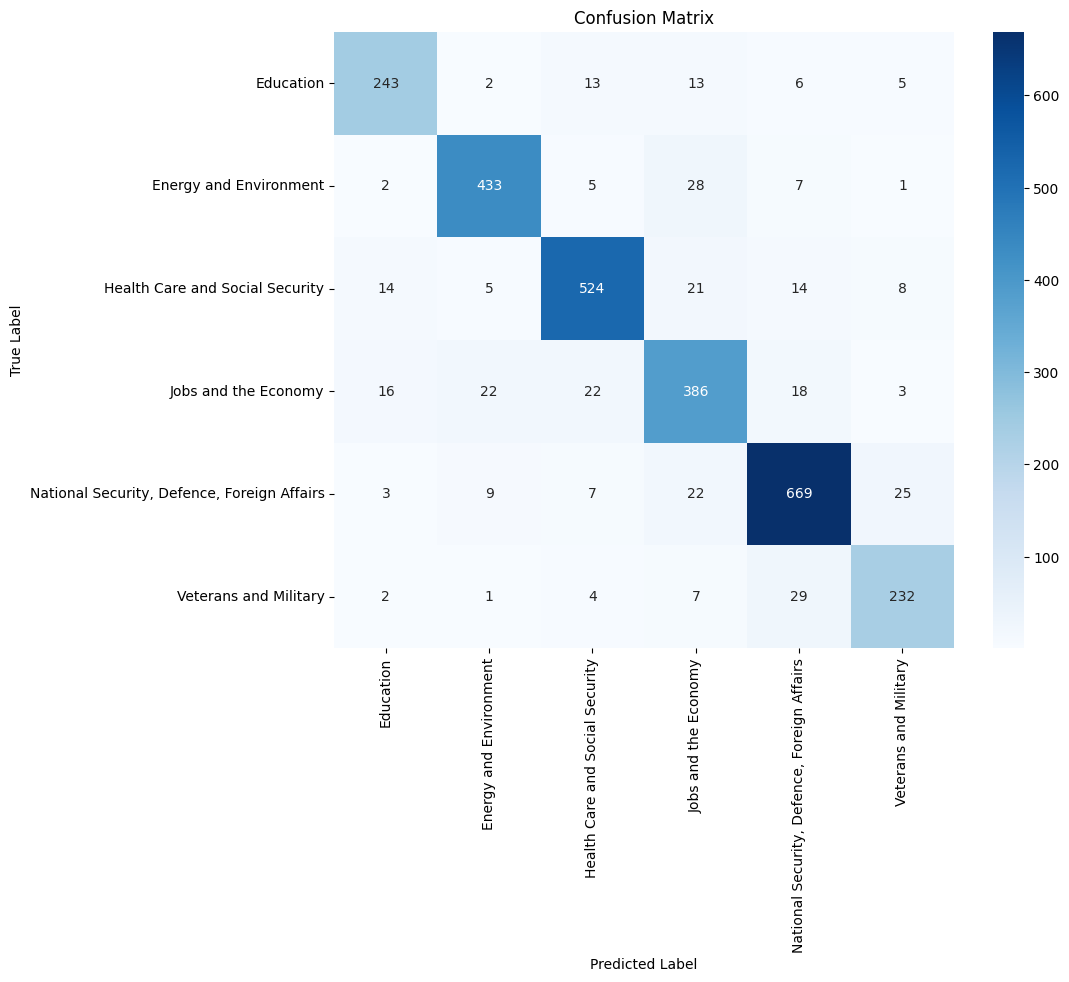

In [41]:
evaluate(model, val_loader)